# NYU PUI HOMEWORK 12 - Part 1 - Time Series Analysis
December 11, 2018

__Author__ = zem232

### Goal: Examine outliers, trends and periodicity in MTA turnstyle data.
Continuation of ../HW11_zem232/HW11_zem232_Part1_Subway.ipynb

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os
import sys

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [2]:
mta = np.load(os.getenv('PUIDATA') + "/MTA_Fare.npy").astype(float)
mta [ mta < 0] = np.nan
print('MTA array shape:', mta.shape)

MTA array shape: (600, 23, 194)


## 4. Manhattan Stations with Prominent Annual Periodicity

Text(0.5,1,'Power Spectrum of MTA Swipes')

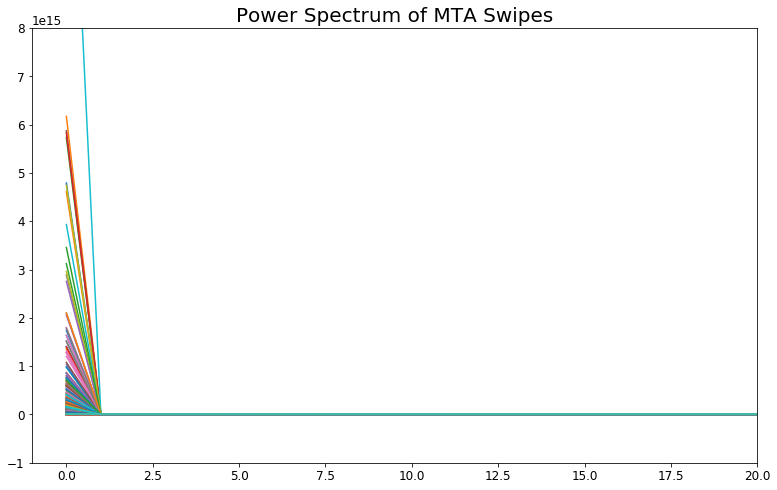

In [3]:
## Summing all ridership type within the mta datacube for each station
stations = np.nansum(mta,axis=1)
## Taking the square of the real portion of the fourier transfer
((np.fft.rfft(stations).real)**2)
period = 3
## plotting
pl.rcParams['font.size'] = 12
pl.figure(figsize=(13,8))
pl.xlim((-1,20))
pl.ylim((-0.1e16,0.8e16))
for i in range(len(stations)):
    pl.plot(np.square((np.fft.rfft(stations[i]).real)))
pl.title ("Power Spectrum of MTA Swipes", size=20)

**Figure 1:** The Fourier transform power spectrum for MTA weekly swipes for 600 different stations in plotted above. The plots are skewed by the power value at frequency 0, which will be the largest value for all data with imperfect periodicity trends (since 0 indicates infinity periodicity). Therefore we have to remove the index value to view the data's other periodic tendencies. 

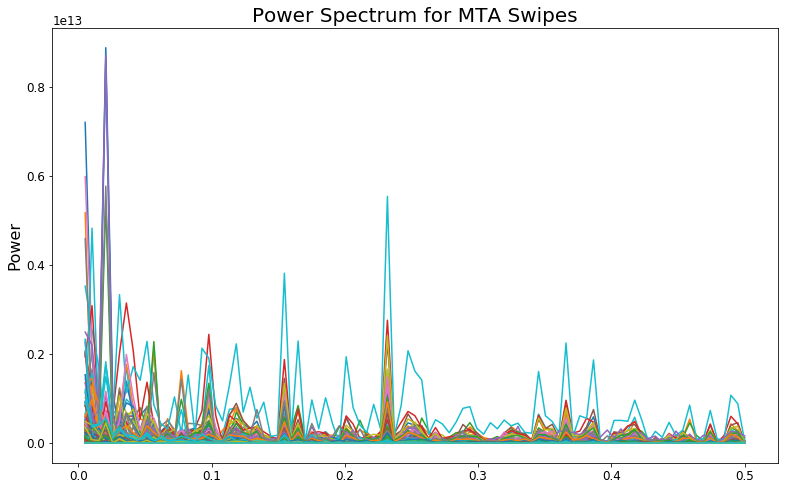

In [4]:
fig=pl.figure(figsize=(13,8))
pl.rcParams['font.size'] = 12
ax=fig.add_subplot(111)
for i in range(len(stations)):
    N = len(stations[i])
    f = np.abs(np.fft.rfft(stations[i]))**2
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
pl.title('Power Spectrum for MTA Swipes', size=20)
pl.ylabel("Power", size=16);

**Figure 2:** The power spectrum for MTA swipes at 600 stations is shown above after removing the first value. It is clear that the data does have common periodic trends among the stations. To describe the x-axis in comprehensive terms refer to Figure 3. 

In [5]:
## Annual trends will have frequency of 1/52 weeks:
1/52

0.019230769230769232

In [6]:
## The fourth index is closest to 0.01923
print('2:',np.fft.rfftfreq(N, 1.0)[2])
print('3:',np.fft.rfftfreq(N, 1.0)[3])
print('4:',np.fft.rfftfreq(N, 1.0)[4])


2: 0.010309278350515464
3: 0.015463917525773196
4: 0.020618556701030927


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


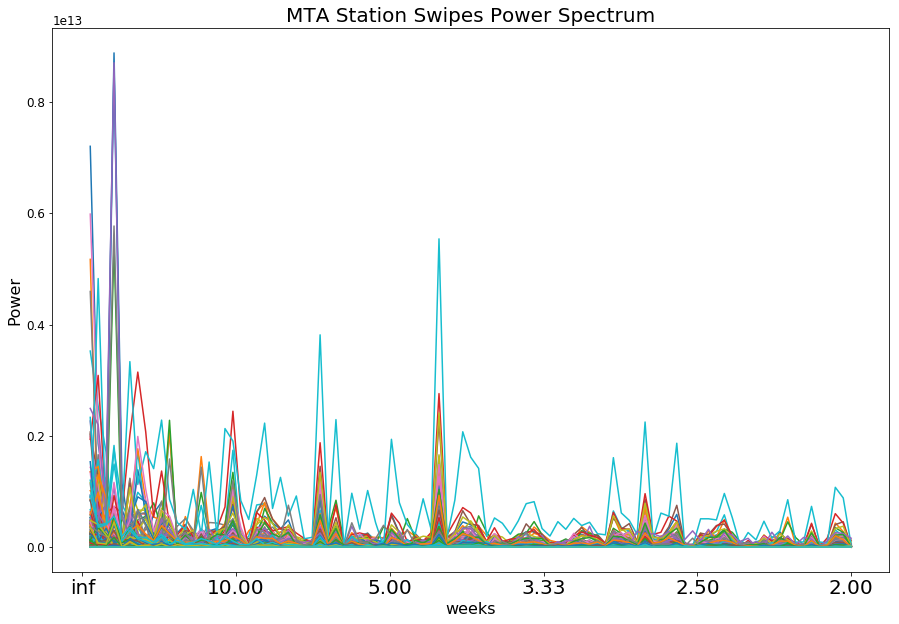

In [7]:
fig = pl.figure(figsize=(15,10))
pl.rcParams['font.size'] = 12
ax = fig.add_subplot(111)
## extracting most significant periodic power for each station
maxperiod = []
## extracting the power for annual trends (1/52 is [3] index)
annual_power = []
for i in range(len(stations)):
    N = len(stations[i])
    f = np.abs(np.fft.rfft(stations[i]))**2
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
    maxperiod.append(max(f[1:]))
    annual_power.append(f[4])
ax.set_xticklabels([ "%.2f"%(1/x) for x in ax.get_xticks()], fontsize=20)
pl.title('MTA Station Swipes Power Spectrum', size=20)
pl.xlabel("weeks", size=16)
pl.ylabel("Power", size=16);

**Figure 3:** There is a strong periodic trend to the very left of the plot, somewhere between infinity and 10 weeks. I speculate that this is the annual trend illustrated here. There is another strong periodic trend between 5 and 3.33 weeks, indicating the monthly trends. This trend is an interesting way to evaluate societal behavior of New Yorkers. They may decide to take the subway closer to the end of the month over taking a taxi/uber closer to when rent is due, or perhaps some will be inspired to use their monthly subscription pass right after they poured out $116 for the month and their enthusiasm for using public transport slowly fades as the month progresses. The monthly will be interesting to further investigate across the different types of ridership subscriptions, as well as determining which stations in Manhattan follow this trend the strongest.

In [8]:
annualt = pd.DataFrame(index=range(len(annual_power)), data=annual_power, columns={'annual_trend'})
annualt['maxperiod'] = maxperiod
annualt.head()

,annual_trend,maxperiod
0,8.881357e+12,8.881357e+12
1,2.681093e+11,5.171070e+12
2,6.127284e+08,3.894866e+09
3,7.811923e+09,7.394896e+10
4,2.751821e+09,2.534033e+10


In [9]:
a = annualt.sort_values('annual_trend', ascending=False).head(4)
print('The stations with the most prominent annual trend have the following index: '+
     '%i, %i, %i, %i'%(a.index[0],a.index[1],a.index[2],a.index[3]))
print(a)

The stations with the most prominent annual trend have the following index: 0, 194, 150, 327
     annual_trend     maxperiod
0    8.881357e+12  8.881357e+12
194  8.704795e+12  8.704795e+12
150  8.596013e+12  8.596013e+12
327  5.770654e+12  5.770654e+12


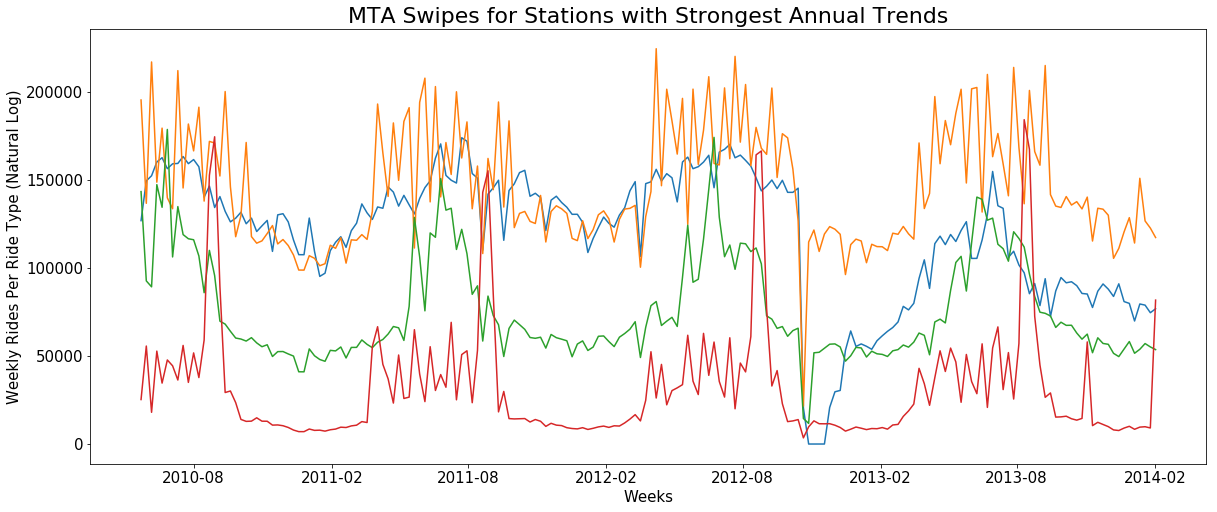

In [10]:
## Plotting the MTA swipes per ride type on a natural log scale
Date = pd.date_range(start='05/19/2010', periods=194, freq='W')
fig = plt.figure(figsize=(20,8))
for i in a.index:
    plt.plot(Date, stations[i].T)
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Weekly Rides Per Ride Type (Natural Log)',size=15)
plt.xlabel('Weeks',size=15)
plt.title('MTA Swipes for Stations with Strongest Annual Trends',size=22)
plt.show()

**Figure 4:** The 4 Manhattan stations with strongest periodic trends are illustrated. It seems that for all of these stations, there is a peak in ridership between the months of April and October, and a dip in ridership for the winter months. This can be attributed to many reasons: during the warmer months, more tourists are in the city and more New Yorkers are willing to go out and enjoy the nice weather. In the winter, people may opt for using a ride sharing service or just not be as active outdoors as in the summer. The subways are also more prone to breaking down and service issues in the winter months, and some snowbirds (mostly elderly New Yorkers) may choose to flock south for the winter months and avoid the cold weather. Another interesting trend for the station with the lower weekly ridership (red line) is its significant peak around September. I speculate that this station is located near a school, probably a University, and that this peak is caused by the influx of students moving, exploring and gathering their bearings before school.

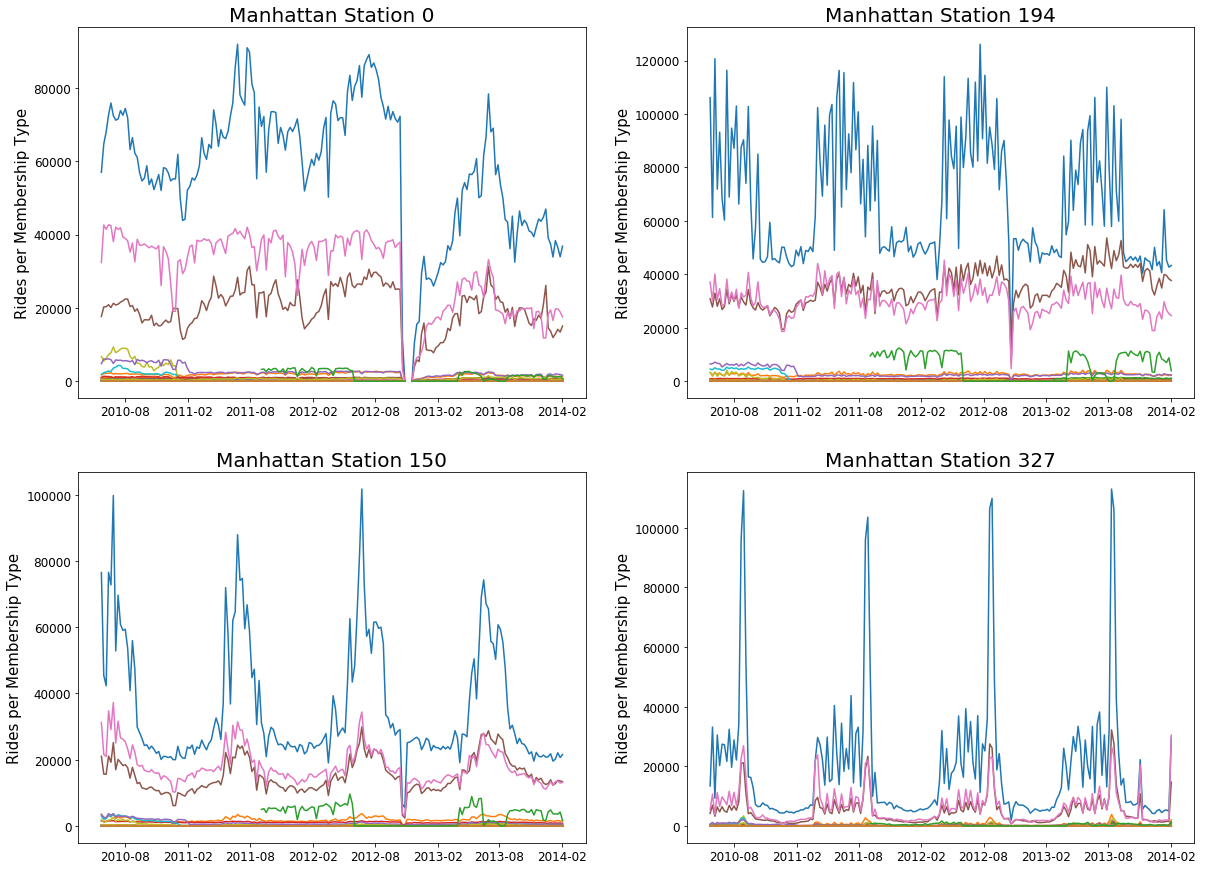

In [24]:
## Plotting the MTA swipes per ride type on a natural log scale
b = a.reset_index()
fig = plt.figure(figsize=(20,15))
pl.rcParams['font.size'] = 12
for i in b.index:
    plt.subplot(2,2,i+1)
    plt.plot(Date, mta[b['index'][i]].T)
    plt.title('Manhattan Station %d'%(b['index'][i]),size=20)
    plt.ylabel('Rides per Membership Type',size=15)
plt.show()

**Figure 5:** For each of the stations with prominent annual periodic trends, the weekly swipes is plotted by ride trip. It seems that for all of these stations, the trends illustrate dips in ridership around the winter months. This is probably due to people going on holiday and students on winter break. 

In [13]:
nanargmax(mta[b['index'][3],:,1])
mta[b['index'][3],:,6]

array([2.7251e+04, 5.2300e+02, 5.0000e+01, 8.4000e+01, 3.7000e+01,
       5.0340e+03, 8.5010e+03, 5.0000e+00, 6.9400e+02, 4.9900e+02,
       5.4000e+01, 2.5900e+02, 0.0000e+00, 6.2000e+01, 1.0070e+03,
       1.9700e+02, 4.2000e+01, 0.0000e+00, 1.3600e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00,        nan])

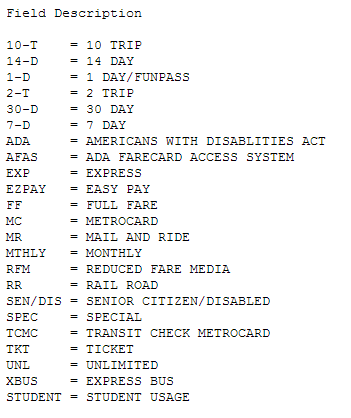

In [14]:
Image(filename = "Ridetypes.png")

### Extra Credit - Time Series Clustering

In [15]:
## Import sklearn's KMeans clustering package
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

np.random.seed(666)

In [16]:
## Create dataframe of the stations time series (summed across all ridership type)
stations_df = pd.DataFrame(data=stations, columns=Date, index=range(0,600))

In [17]:
## Normalizing the dataframe for each station
## This allows us to provide adequate comparisons 
stations_df.dropna(axis=0,inplace=True)
vals = ((stations_df.T - stations_df.mean(1)) / stations_df.std(1)).T
vals.dropna(axis=0,inplace=True)
print(vals.mean(axis=1).shape)
vals.head()

(471,)


,2010-05-23 00:00:00,2010-05-30 00:00:00,2010-06-06 00:00:00,2010-06-13 00:00:00,2010-06-20 00:00:00,2010-06-27 00:00:00,2010-07-04 00:00:00,2010-07-11 00:00:00,2010-07-18 00:00:00,2010-07-25 00:00:00,...,2013-12-01 00:00:00,2013-12-08 00:00:00,2013-12-15 00:00:00,2013-12-22 00:00:00,2013-12-29 00:00:00,2014-01-05 00:00:00,2014-01-12 00:00:00,2014-01-19 00:00:00,2014-01-26 00:00:00,2014-02-02 00:00:00
0,0.202071,0.811194,0.889521,1.099543,1.166010,0.998171,1.072077,1.077953,1.183368,1.074665,...,-0.846555,-0.958359,-0.764940,-1.036982,-1.064394,-1.334199,-1.073585,-1.091078,-1.207247,-1.146818
1,0.889935,1.379618,1.534415,1.293263,1.114671,0.801602,1.140337,1.136060,1.098898,1.095048,...,-1.104835,-1.104835,-1.104835,-1.104835,-1.104835,-1.104835,-1.104835,-1.104835,-1.104835,-1.104835
2,-0.649826,-0.369790,-0.015416,-1.540852,-0.216024,-2.176280,-1.779137,-1.605005,-1.720075,-0.307673,...,1.042612,-1.340244,-1.617225,0.428569,1.153609,0.100671,0.507997,0.943836,0.675001,-0.462457
3,-0.834317,-0.508762,-0.449656,-1.509448,-0.451552,-1.848910,-1.424741,-1.463302,-1.516086,-0.580826,...,1.400951,-0.881728,-1.084646,0.881327,1.427501,0.501407,0.743519,1.087722,1.186969,0.004857
4,-0.737333,-0.191135,-0.172779,-1.752226,-0.036128,-2.353900,-1.721632,-1.756305,-1.699605,-0.306983,...,1.082375,-0.864195,-1.255793,0.453778,0.874746,0.076865,0.640603,1.187617,1.066874,0.485595


Number of zip codes in g line cluster: 141
Number of zip codes in c line cluster: 189
Number of zip codes in pink line cluster: 52
Number of zip codes in y line cluster: 68
Number of zip codes in b line cluster: 21
(g: green ; c: cyan ; y: yellow ; b: blue)


Text(0.5,1,'Manhattan Subway Stations Clustered by Weekly Swipe Patterns (k=5)')

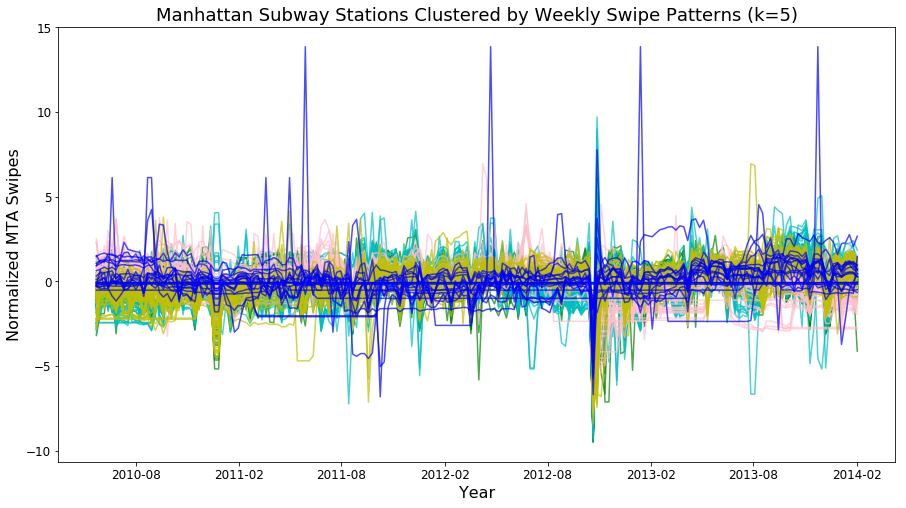

In [21]:
## Using KMeans for various k values to find the best fit
nc = 5
km = KMeans(n_clusters=nc, random_state=444)
labels = km.fit(vals).labels_
cluster = km.fit_predict(vals)
colors = ['g','c','pink','y','b','w']
plt.figure(figsize=(15, 8))
x = vals.columns
for u in unique(labels):
    for z in vals[cluster==u].index:
        y = vals[vals.index == z].values.T
        plt.plot(x,y, color=colors[u], alpha = 0.7)
    print('Number of zip codes in %s line cluster: %i'%(colors[u],len(vals[cluster==u])))
print('(g: green ; c: cyan ; y: yellow ; b: blue)')

plt.xlabel('Year', fontsize = 16)
plt.ylabel('Normalized MTA Swipes', fontsize = 16)
plt.title('Manhattan Subway Stations Clustered by Weekly Swipe Patterns (k=5)', fontsize = 18)

**Figure 6:** Manhattan subway stations, clustered by weekly swipe patterns using K-means clustering for k=5. The different clusters seem to have similar patterns, so I will try for fewer clusters.

Number of zip codes in g line cluster: 64
Number of zip codes in c line cluster: 179
Number of zip codes in pink line cluster: 142
Number of zip codes in y line cluster: 86
(g: green ; c: cyan ; y: yellow )


Text(0.5,1,'Manhattan Subway Stations Clustered by Weekly Swipe Patterns (k=4)')

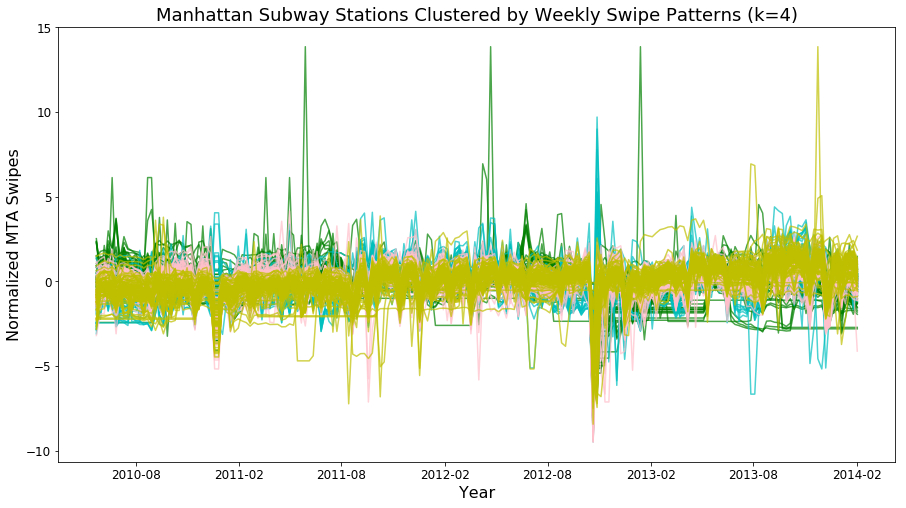

In [22]:
nc = 4
km = KMeans(n_clusters=nc, random_state=444)
labels = km.fit(vals).labels_
cluster = km.fit_predict(vals)
plt.figure(figsize=(15, 8))
x = vals.columns
for u in unique(labels):
    for z in vals[cluster==u].index:
        y = vals[vals.index == z].values.T
        plt.plot(x,y, color=colors[u], alpha = 0.7)
    print('Number of zip codes in %s line cluster: %i'%(colors[u],len(vals[cluster==u])))
print('(g: green ; c: cyan ; y: yellow )')

plt.xlabel('Year', fontsize = 16)
plt.ylabel('Normalized MTA Swipes', fontsize = 16)
plt.title('Manhattan Subway Stations Clustered by Weekly Swipe Patterns (k=4)', fontsize = 18)

**Figure 7:** Manhattan subway stations, clustered by weekly swipe patterns using K-means clustering for k=4. The yellow and pink line patterns look very similar, suggesting the number of clusters is not entirely justified. 

Number of zip codes in g line cluster: 280
Number of zip codes in c line cluster: 123
Number of zip codes in pink line cluster: 68
(g: green ; c: cyan ; y: yellow )


Text(0.5,1,'Manhattan Subway Stations Clustered by Weekly Swipe Patterns (k=3)')

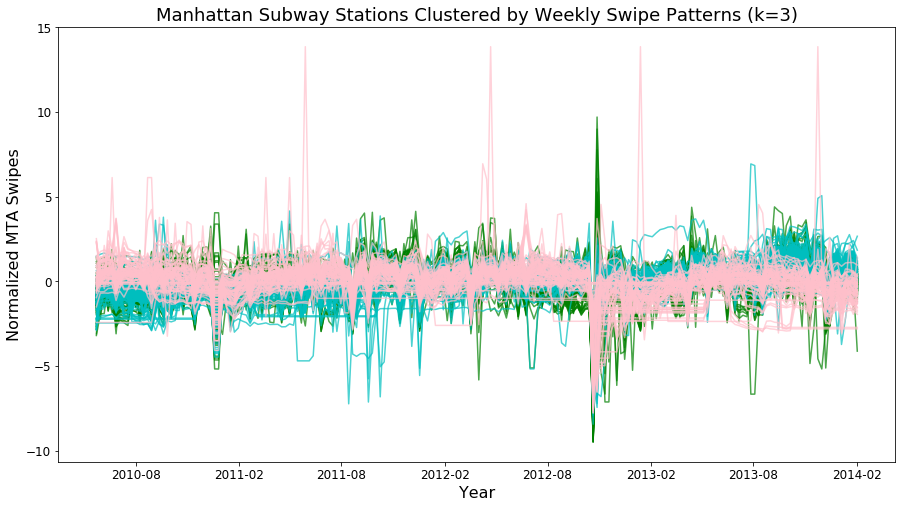

In [23]:
nc = 3
km = KMeans(n_clusters=nc, random_state=444)
labels = km.fit(vals).labels_
cluster = km.fit_predict(vals)
plt.figure(figsize=(15, 8))
x = vals.columns
for u in unique(labels):
    for z in vals[cluster==u].index:
        y = vals[vals.index == z].values.T
        plt.plot(x,y, color=colors[u], alpha = 0.7)
    print('Number of zip codes in %s line cluster: %i'%(colors[u],len(vals[cluster==u])))
print('(g: green ; c: cyan ; y: yellow )')

plt.xlabel('Year', fontsize = 16)
plt.ylabel('Normalized MTA Swipes', fontsize = 16)
plt.title('Manhattan Subway Stations Clustered by Weekly Swipe Patterns (k=3)', fontsize = 18)

**Figure 6:** Manhattan subway stations, clustered by weekly swipe patterns using K-means clustering for k=3. The clusters seem to each have different trends. The pink lines have sharper peaks and more annual periodicity. The blue lines are more erratic and the green lines shower more frequent periodicity, such as monthly.